In [1]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import joblib 
from sklearn.pipeline import Pipeline
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
import statsmodels.api as sm
from scipy import stats
import shap
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
## load data
data = pd.read_csv('train_data.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,320,July,0,0,2,0.0,0,BB,...,0,0,0,C,3,0,Transient,38.4,0,0
1,Resort Hotel,0,320,July,0,0,2,0.0,0,BB,...,0,0,0,C,4,0,Transient,38.4,0,0
2,Resort Hotel,0,7,July,0,1,1,0.0,0,BB,...,0,0,0,A,0,0,Transient,75.0,0,0
3,Resort Hotel,0,13,July,0,1,1,0.0,0,BB,...,0,0,0,A,0,0,Transient,75.0,0,0
4,Resort Hotel,0,14,July,0,2,2,0.0,0,BB,...,0,0,0,A,0,0,Transient,98.0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_month              119390 non-null  object 
 4   stays_in_weekend_nights         119390 non-null  int64  
 5   stays_in_week_nights            119390 non-null  int64  
 6   adults                          119390 non-null  int64  
 7   children                        119390 non-null  float64
 8   babies                          119390 non-null  int64  
 9   meal                            119390 non-null  object 
 10  country                         119390 non-null  object 
 11  market_segment                  119390 non-null  object 
 12  distribution_cha

In [5]:
categorical = ['arrival_date_month', 'customer_type', 'meal', 'country', 
               'market_segment', 'distribution_channel', 'reserved_room_type', 'hotel']

In [6]:
## create object of Binaryencoding
encoder = ce.BinaryEncoder(categorical)
enc = encoder.fit(data[categorical].values)
dfbin = enc.transform(data[categorical].values)
dfbin.columns = [enc.verbose[int(i.split('_')[0])]+"_"+i.split('_')[1] for i in dfbin.columns]
data = pd.concat([data, dfbin], axis = 1)

In [7]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'arrival_date_month_0', 'arrival_date_month_1', 'arrival_date_month_2',
       'arrival_date_month_3', 'arrival_date_month_4', 'customer_type_0',
       'customer_type_1', 'customer_type_2', 'meal_0', 'meal_1', 'meal_2',
       'meal_3', 'country_0', 'country_1', 'country_2', 'country_3',
       'country_4', 'country_5', 'country_6', 'country_7', 'country_8',
       'market_segment_0', 'market_segment_1', 'market_segment_2',
       'market_segment_3', 'distribution_channel_0', 'distribution_channel_1',
   

In [8]:
X = data.drop(['arrival_date_month', 'customer_type', 'meal', 'country', 'market_segment', 
               'babies', 'distribution_channel', 'reserved_room_type', 'hotel', 'is_canceled',
               'customer_type_0', 'reserved_room_type_0', 'distribution_channel_0', 'meal_0',
               'arrival_date_month_0', 'country_0', 'hotel_1'], axis=1).copy()

Y = data['is_canceled'] 

train, test, ytrain, ytest = train_test_split(X, Y, test_size = 0.2, random_state = 42)
train.shape, test.shape

((95512, 42), (23878, 42))

In [9]:
Y.value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [10]:
model = xgb.XGBClassifier(learning_rate = 0.01, n_estimators = 500,
 max_depth = 6,
 gamma = 0.5,
 subsample = 0.8,
 colsample_bytree = 1.0,
 reg_alpha = 0.1,
 objective = 'binary:logistic',
 scale_pos_weight = 2,
 eval_metric = 'logloss')

model = model.fit(train, ytrain)

ypred = model.predict(test.values)

In [11]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.85     14907
           1       0.73      0.84      0.78      8971

    accuracy                           0.83     23878
   macro avg       0.81      0.83      0.82     23878
weighted avg       0.83      0.83      0.83     23878



In [12]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs,
                                            drop_intermediate = False)
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [13]:
probs = model.predict_proba(test.values)
probs = probs[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(ytest, probs, drop_intermediate = False)

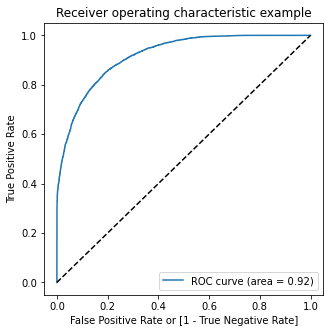

In [14]:
draw_roc(ytest, probs)

In [15]:
feature_importances = pd.DataFrame(model.feature_importances_,index = train.columns,columns = ['importance']).sort_values('importance',ascending = False)
display_side_by_side(feature_importances)

,importance
market_segment_3,0.100723
total_of_special_requests,0.088848
previous_cancellations,0.078760
required_car_parking_spaces,0.076018
country_6,0.064970
customer_type_1,0.064567
country_7,0.060971
lead_time,0.052470
booking_changes,0.049949
country_5,0.047831


In [16]:
feature_importances = feature_importances.reset_index()

In [17]:
probs = model.predict_proba(test.values)
prob = probs[:, 1]
df = pd.DataFrame()
df['is_canceled'] = ytest
df['prob'] = prob
df['prob_bin'] = pd.qcut(df['prob'], 10)

In [18]:
db1 = df[['prob_bin', 'is_canceled']].groupby(['prob_bin']).agg(['count','sum','mean']).reset_index()
db1['%'] = db1[('is_canceled', 'sum')]/db1[('is_canceled', 'count')] * 100
db1

prob_bin is_canceled                           %
                          count   sum      mean            
0  (0.00338, 0.028]        2388     0  0.000000    0.000000
1   (0.028, 0.0865]        2388    16  0.006700    0.670017
2     (0.0865, 0.2]        2388    86  0.036013    3.601340
3      (0.2, 0.335]        2387   293  0.122748   12.274822
4    (0.335, 0.434]        2388   519  0.217337   21.733668
5     (0.434, 0.54]        2388   804  0.336683   33.668342
6     (0.54, 0.711]        2388  1175  0.492044   49.204355
7    (0.711, 0.819]        2387  1616  0.677000   67.700042
8    (0.819, 0.946]        2396  2082  0.868948   86.894825
9    (0.946, 0.995]        2380  2380  1.000000  100.000000

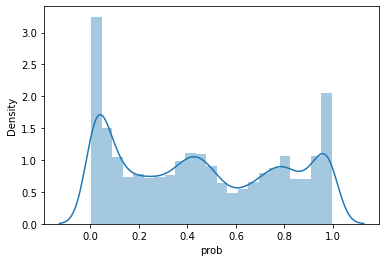

In [19]:
sns.distplot(df['prob'])

In [20]:
df['probability'] = pd.cut(df['prob'], bins=10, precision=1)

In [21]:
db1 = df[['probability', 'is_canceled']].groupby(['probability']).agg(['count','sum','mean']).reset_index()
db1['%'] = db1[('is_canceled', 'sum')]/db1[('is_canceled', 'count')] * 100
db1

probability is_canceled                          %
                      count   sum      mean           
0  (0.003, 0.1]        5273    28  0.005310   0.531007
1    (0.1, 0.2]        1954    77  0.039406   3.940635
2    (0.2, 0.3]        1728   195  0.112847  11.284722
3    (0.3, 0.4]        2058   384  0.186589  18.658892
4    (0.4, 0.5]        2578   737  0.285881  28.588053
5    (0.5, 0.6]        1475   609  0.412881  41.288136
6    (0.6, 0.7]        1413   731  0.517339  51.733900
7    (0.7, 0.8]        2085  1349  0.647002  64.700240
8    (0.8, 0.9]        1898  1497  0.788725  78.872497
9    (0.9, 1.0]        3416  3364  0.984778  98.477752

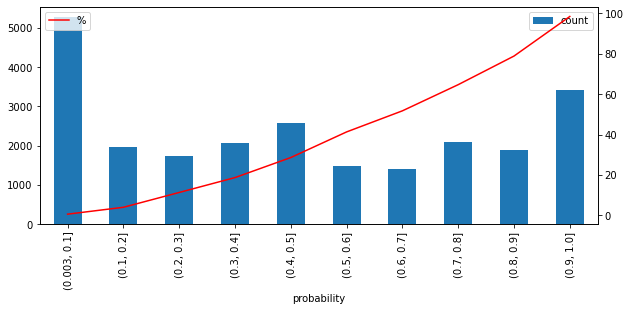

In [22]:
db1['count'] = db1[('is_canceled','count')]
fig, ax = plt.subplots(figsize=(10,4))
ax2 = ax.twinx()
db1.plot(x='probability', y='%', ax=ax2, color = 'red')
db1.plot(x='probability', y='count', ax=ax, kind='bar')